# Image and Video Processing 
## Project: Image Stegnography

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import deque
import random
%matplotlib inline

### Some basic useful functions 

In [117]:
def convertToGray(I):
    '''Converts an RGB image to grayscale image.'''
    if(len(I.shape)==2):
        return I
    I = 0.2126 * I[: , : , 0] + 0.7152 * I[: , : , 1] + 0.0722 * I[: , : , 2]
    I = np.round(I)
    I = I.astype(np.int64)
    return I

# Assuming I is I 256 gray levels.
def histogram(I):
    '''Computes the histogram of an I.'''
    hist = np.zeros(256)
    M, N = I.shape
    for i in range(M):
        for j in range(N): hist[I[i][j]] += 1
    
    return hist

def point_op(I, P = 1, L = 0, K = 255):
    '''Performs point operation on I.
    I: input image.
    P: scale factor.
    L: shift.
    K: maximum pixel value.'''
    P_new = P*I + L
    P_new = np.round(P_new)
    P_new = P_new.astype(np.int64)
    
    # clipping to 0 and 255
    P_new = np.maximum(P_new, 0) 
    P_new = np.minimum(P_new, K)
    
    return P_new

def FSCS(I):
    '''Performs Full Scale Contrast Stretching on I.
    I: input image.'''
    
    A = np.min(I)
    B = np.max(I)
    
    # as per results in class
    P = 255 / (B - A)
    L = -1 * A * 255 / (B - A)
    
    return point_op(I, P = P, L = L)

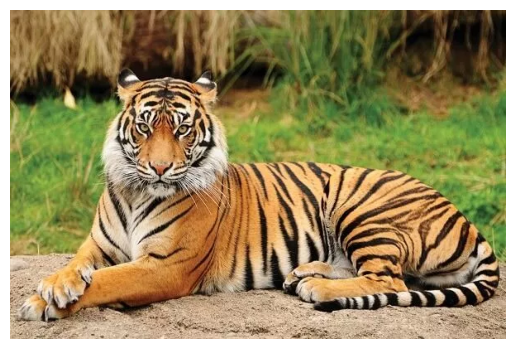

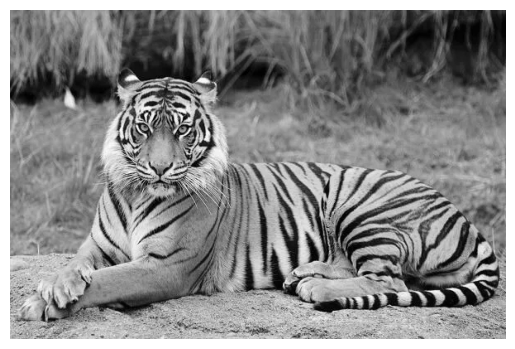

In [118]:
# import I
img = Image.open('Images/tiger.jpg')
img = np.asarray(img)

# convert to grayscale
gray_img = convertToGray(img)

# show I
plt.imshow(img)
plt.axis('off')
plt.show()

plt.imshow(gray_img, cmap='gray')
plt.axis('off')
plt.show()

# # show histogram
# hist = histogram(gray_img)

# plt.bar(np.arange(256), hist, color='black')
# plt.title('Histogram')
# plt.xlabel('Intensity Levels')
# plt.ylabel('Frequency')
# plt.show()

### (R, G, B) -> (L, a, b)

In [119]:

def convertToLAB(I):
    '''Converts an RGB image to LAB image.
    Input, I: RGB image.'''
    
    m , n , p = I.shape
    
    I_result = np.zeros((m,n,p))
    
    X = 0.412453 * I[:,:,0] + 0.357580 * I[:,:,1] + 0.180423 * I[:,:,2]
    Y = 0.212671 * I[:,:,0] + 0.715160 * I[:,:,1] + 0.072169 * I[:,:,2]
    Z = 0.019334 * I[:,:,0] + 0.119193 * I[:,:,1] + 0.950227 * I[:,:,2]
    
    X = X / 0.950456
    Z = Z / 1.088754
    
    L = np.where(Y>0.008856,116*(abs(Y)**(1/3))-16,903.3*Y)
    delta=128
    
    a = 500*( np.where(X>0.008856,abs(X)**(1/3),7.787 * X + 16/116) - np.where(Y > 0.008856, abs(Y) ** (1/3), 7.787 * Y + 16/116)  ) + delta
    b = 200*( np.where(Y > 0.008856, abs(Y) ** (1/3), 7.787 * Y + 16/116) - np.where(Z > 0.008856, np.abs(Z) ** (1/3), 7.787 * Z + 16/116) ) + delta
    
    I_result[:,:,0] = L*(255/100)
    I_result[:,:,1] = a
    I_result[:,:,2] = b
    
    return I_result


In [120]:
def convertToRGB(I):
    '''Converts an LAB image to RGB image.
    Input, I: LAB image.'''
    m , n , p = I.shape
    
    L, a, b = I[:,:,0], I[:,:,1], I[:,:,2]
    
    L = L*(100/255)
    y = np.where(L>7.9996248,((L+16)/116)**3,L/903.3)
    delta=128
    
    fx = (a-delta)/500 + np.where(y > 0.008856, y ** (1/3), 7.787 * y + 16/116)
    fz = ( -b + delta )/200 + np.where(y > 0.008856, y ** (1/3), 7.787 * y + 16/116)
    
    x = np.where(fx>0.20689303442,fx**3, (fx - 16/116)/7.787)
    z = np.where(fz>0.20689303442,fz**3, (fz - 16/116)/7.787)
    
    x = x*0.950456
    z= z*1.088754
    
    I_result = np.zeros((m,n,p))
    
    I_result[:,:,0] = 3.24048134*x -1.53715152*y -0.49853633*z
    I_result[:,:,1] = -0.96925495*x+1.87599*y+0.04155593*z
    I_result[:,:,2] = 0.05564664*x-0.20404134*y+1.05731107*z
    
    return I_result

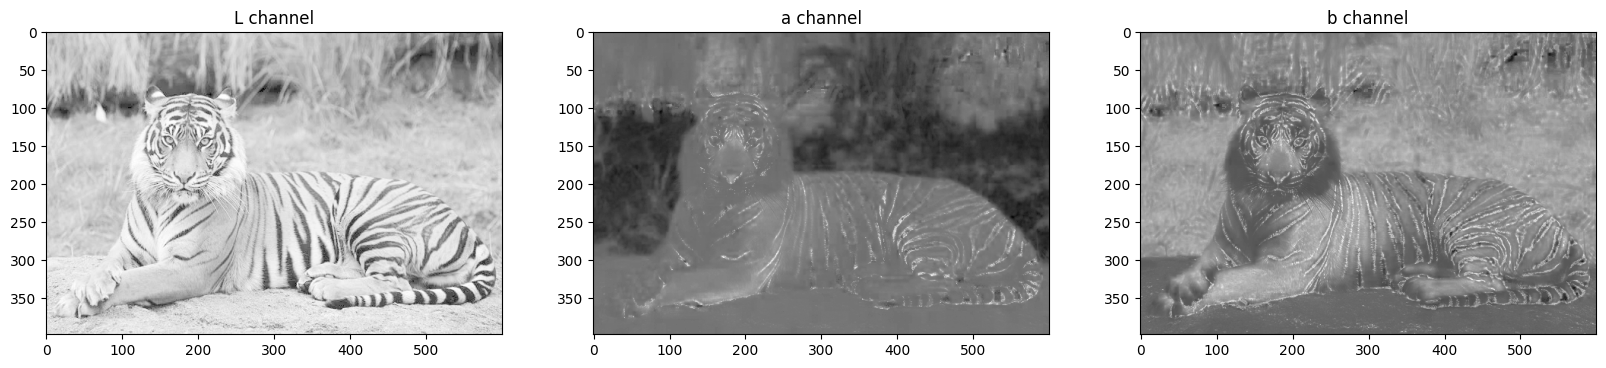

In [121]:
lgb_img = convertToLAB(img)

plt.figure(figsize=(20, 7))

plt.subplot(1, 3, 1)
plt.imshow(lgb_img[:,:,0], cmap='gray')
plt.title('L channel')

plt.subplot(1, 3, 2)
plt.imshow(lgb_img[:,:,1], cmap='gray')
plt.title('a channel')

plt.subplot(1, 3, 3)
plt.imshow(lgb_img[:,:,2], cmap='gray')
plt.title('b channel')

plt.show()

### DFT-IDFT Functions

In [122]:
def DFT(I, centered=False):
    '''Computes the 2D DFT of an image using matrix multiplication.
    Input: I, a 2D numpy array.
    Parameter centered: if True, the phase will be centered.
    Returns the magnitude and phase of the 2D DFT.'''
    M, N = I.shape
    
    I = I.copy()
        
    if(centered):
        for i in range(M):
            for j in range(N):
                I[i][j] *= (-1)**(i+j)
    
    # declaring matrices of complex exponential
    W_N = np.zeros([N,N], dtype=np.complex128)
    W_M = np.zeros([M,M], dtype=np.complex128)
    
    for u in range(N): 
        for i in range(N):
            W_N[u][i] = u*i
            
    for v in range(M): 
        for j in range(M):
            W_M[v][j] = v*j
    
    W_N = np.exp(-2*np.pi*1j/N) ** W_N
    W_M = np.exp(-2*np.pi*1j/M) ** W_M
    
    dft = np.matmul(np.matmul(W_M, I), W_N)
    
    return np.abs(dft), np.angle(dft)  

def IDFT(mag, phase, centered=False, imgi=False):
    '''Computes the 2D IDFT of an image.
    Input: mag, the magnitude of the 2D DFT.
           phase, the phase of the 2D DFT.
           centered: if True, origin will be conisdered at the center.
           imgi: if True, both real and imaginary parts will be returned. (return: real_part + j*imaginary_part)
    Returns the 2D IDFT of the image using the IDFT matrix.'''
    I = mag * np.exp(1j * phase)
    M, N = I.shape
    
    # declaring matrices of complex exponential
    W_N = np.zeros([N,N], dtype=np.complex128)
    W_M = np.zeros([M,M], dtype=np.complex128)
    
    for u in range(N): 
        for i in range(N):
            W_N[u][i] = u*i
            
    for v in range(M): 
        for j in range(M):
            W_M[v][j] = v*j
    
    W_N = np.exp(2*np.pi*1j/N) ** W_N
    W_M = np.exp(2*np.pi*1j/M) ** W_M
    
    idft = np.matmul(np.matmul(W_M, I), W_N)
    idft = idft/(M*N)
    
    if(centered):
        for i in range(M):
            for j in range(N):
                idft[i][j] *= (-1)**(i+j)
                
    if imgi: return idft
    
    return np.real(idft)

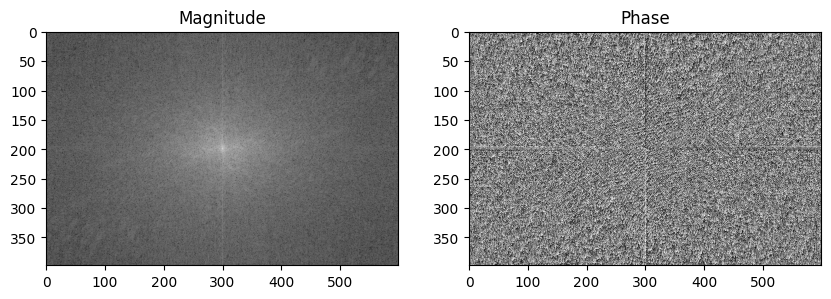

In [123]:
dft_mag, dft_phase = DFT(gray_img, centered=True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.log(1 + dft_mag), cmap='gray')
plt.title('Magnitude')

plt.subplot(1, 2, 2)
plt.imshow(dft_phase, cmap='gray')
plt.title('Phase')
plt.show()


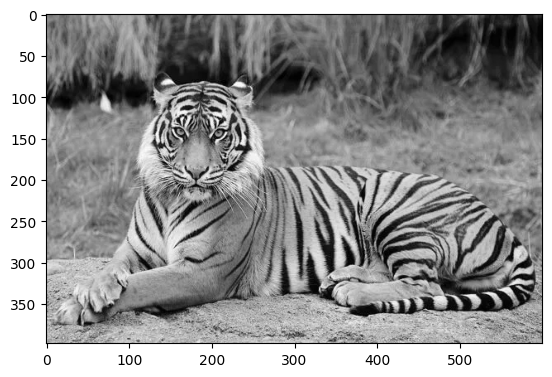

In [124]:
I = IDFT(dft_mag, dft_phase, centered=True)

plt.imshow(np.real(I), cmap='gray')
plt.show()

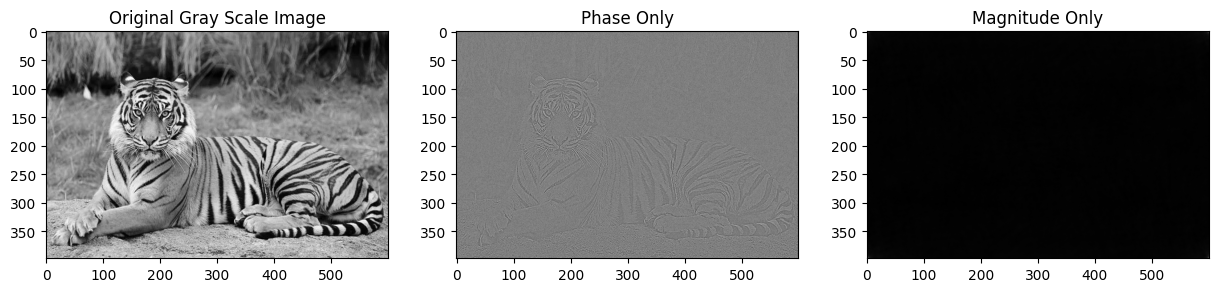

In [125]:
# Inverse fourier transform of the phase only and magnitude only image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('Original Gray Scale Image')

I = np.real(IDFT(np.ones_like(dft_mag), dft_phase, centered=True))
plt.subplot(1, 3, 2)
plt.imshow(I, cmap='gray')
plt.title('Phase Only')

I = np.real(IDFT(dft_mag, np.zeros_like(dft_phase), centered=True))
plt.subplot(1, 3, 3)
plt.imshow(I, cmap='gray')
plt.title('Magnitude Only')

plt.show()

### Encoder-Decoder

(256, 256)


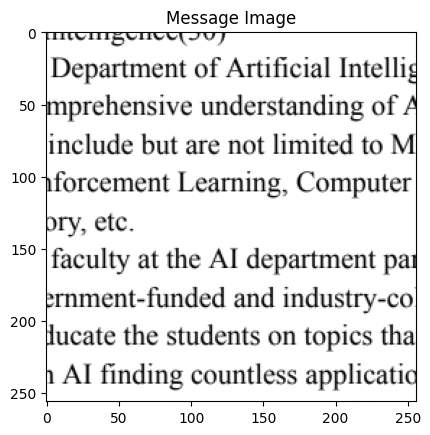

In [126]:
msg = Image.open('Images/message.png')
msg = np.asarray(msg)
msg = convertToGray(msg)

print(msg.shape)

plt.imshow(msg, cmap='gray')
plt.title('Message Image')
plt.show()

In [127]:
def encoder(carrier, mssg):
    '''Encodes a message into a carrier image using DFT.
    Input: carrier, the image in which the message is to be encoded.
           mssg, the message image to be encoded.
           Returns key1, key2, the keys to decode the message.
                   outr, outi, the real and imaginary parts of the encoded image.'''
                   
    lab = convertToLAB(carrier)
    l, a, b = lab[:,:,0],lab[:,:,1],lab[:,:,2]
    
    Ma,Pa = DFT(a)
    Mb, Pb = DFT(b)
    
    n, m = Ma.shape
    
    q=deque()
    for i in range(0,n):
        for j in range(0,m):
            q.append(i*m+j)
    hn, hm=mssg.shape
    
    random.seed(0)
    key1 ,key2= random.sample(q,(hn*hm)//2), random.sample(q,hn*hm-(hn*hm)//2)
    
    Ma, Mb, mssg = Ma.flatten(), Mb.flatten(), mssg.flatten()
    
    Ma[key1] = mssg[0:len(key1)]
    Mb[key2] = mssg[len(key1):]
    
    Ma,Mb,mssg = Ma.flatten(),Mb.flatten(),mssg.flatten()
    
    msg = np.zeros(len(key1)+len(key2))
    
    msg[0:len(key1)]= Ma[key1]
    msg[len(key1):]=Mb[key2]
    
    Ma,Mb= Ma.reshape(n,m), Mb.reshape(n,m)
    
    labr,labi=np.zeros(lab.shape,dtype='float'),np.zeros(lab.shape,dtype='float')
    labr[:,:,0]=lab[:,:,0]
    
    iffa,iffb = IDFT(Ma,Pa,imgi=True),IDFT(Mb,Pb,imgi=True)
    labr[:,:,1],labi[:,:,1],labr[:,:,2],labi[:,:,2]=np.real(iffa),np.imag(iffa),np.real(iffb),np.imag(iffb)
    
    outr , outi = convertToRGB(labr) ,convertToRGB(labi)
    key1.append(hn)
    
    return key1, key2, outr, outi

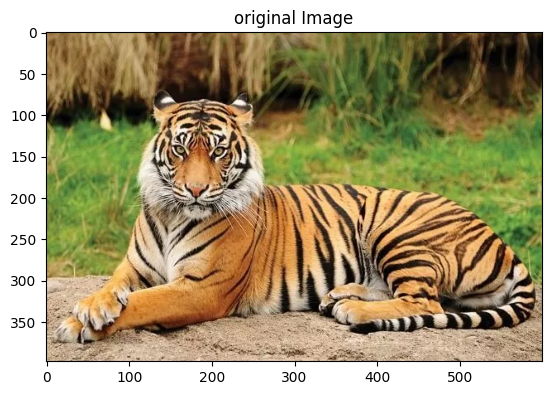

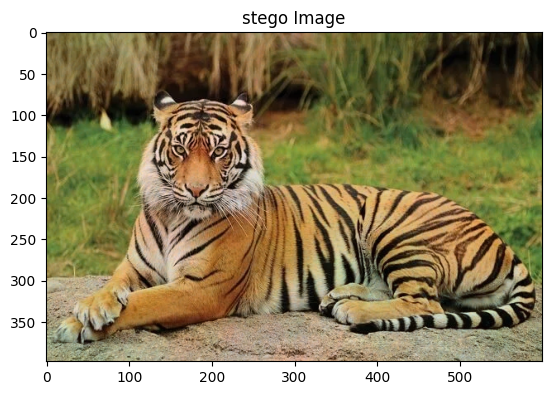

In [128]:
key1, key2, outr, outi = encoder(img.copy(), msg.copy())

plt.imshow(img)
plt.title('original Image')
plt.show()

plt.imshow(FSCS(outr))
plt.title('stego Image')
plt.show()

In [129]:
def decoder(key1, key2, outr, outi):
    '''Decodes a message from a carrier image using DFT.
    Input: key1, key2, the keys to decode the message.
           outr, outi, the real and imaginary parts of the encoded image.
           Returns the decoded message.'''
           
    inr, ini = convertToLAB(outr), convertToLAB(outi)
    dfta = DFT(inr[:,:,1] + 1j*ini[:,:,1])
    dftb = DFT(inr[:,:,2] + 1j*ini[:,:,2])
    
    r1,_ = np.abs(dfta), np.angle(dfta)
    r2,_ = np.abs(dftb), np.angle(dftb)
    r1, r2 = r1.flatten(), r2.flatten()
    
    mssg = np.zeros(len(key1)+len(key2)-1)
    
    hn=key1.pop()
    
    mssg[0:len(key1)] = r1[key1]
    mssg[len(key1):] = r2[key2]
    
    mssg = mssg.reshape(hn, len(mssg)//hn)
    
    return mssg

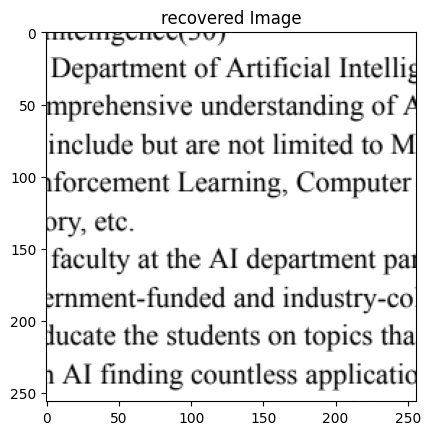

In [130]:
mssga = decoder(key1, key2, outr, outi)
plt.imshow(mssga, cmap='gray')
plt.title('recovered Image')
plt.show()